In [1]:
# Change directory to the parent directory
import os
os.path.abspath(os.curdir)
os.chdir("..")
os.getcwd()

import numpy as np
import pandas as pd
from source import *

from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# Data Processing

In [2]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('./data/cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('./data/EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('./data/natgas_futures_price.csv', sep=',')

In [3]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)

# Futures prices
natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%Y-%m-%d')
natgas_futures.set_index('Date', inplace=True)
# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

data.index = natgas_futures.index
data.dropna(inplace = True)
data = data.loc[data.index <= '2023-05-26']
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1991-01-03,1.782,-2.767194,1991-01,101.211242,13
1991-01-04,1.743,-2.212856,1991-01,101.211242,13
1991-01-07,1.785,2.381065,1991-01,101.211242,13
1991-01-08,1.786,0.056007,1991-01,101.211242,13
1991-01-09,1.728,-3.301381,1991-01,101.211242,13


# Exploratory Data Analysis

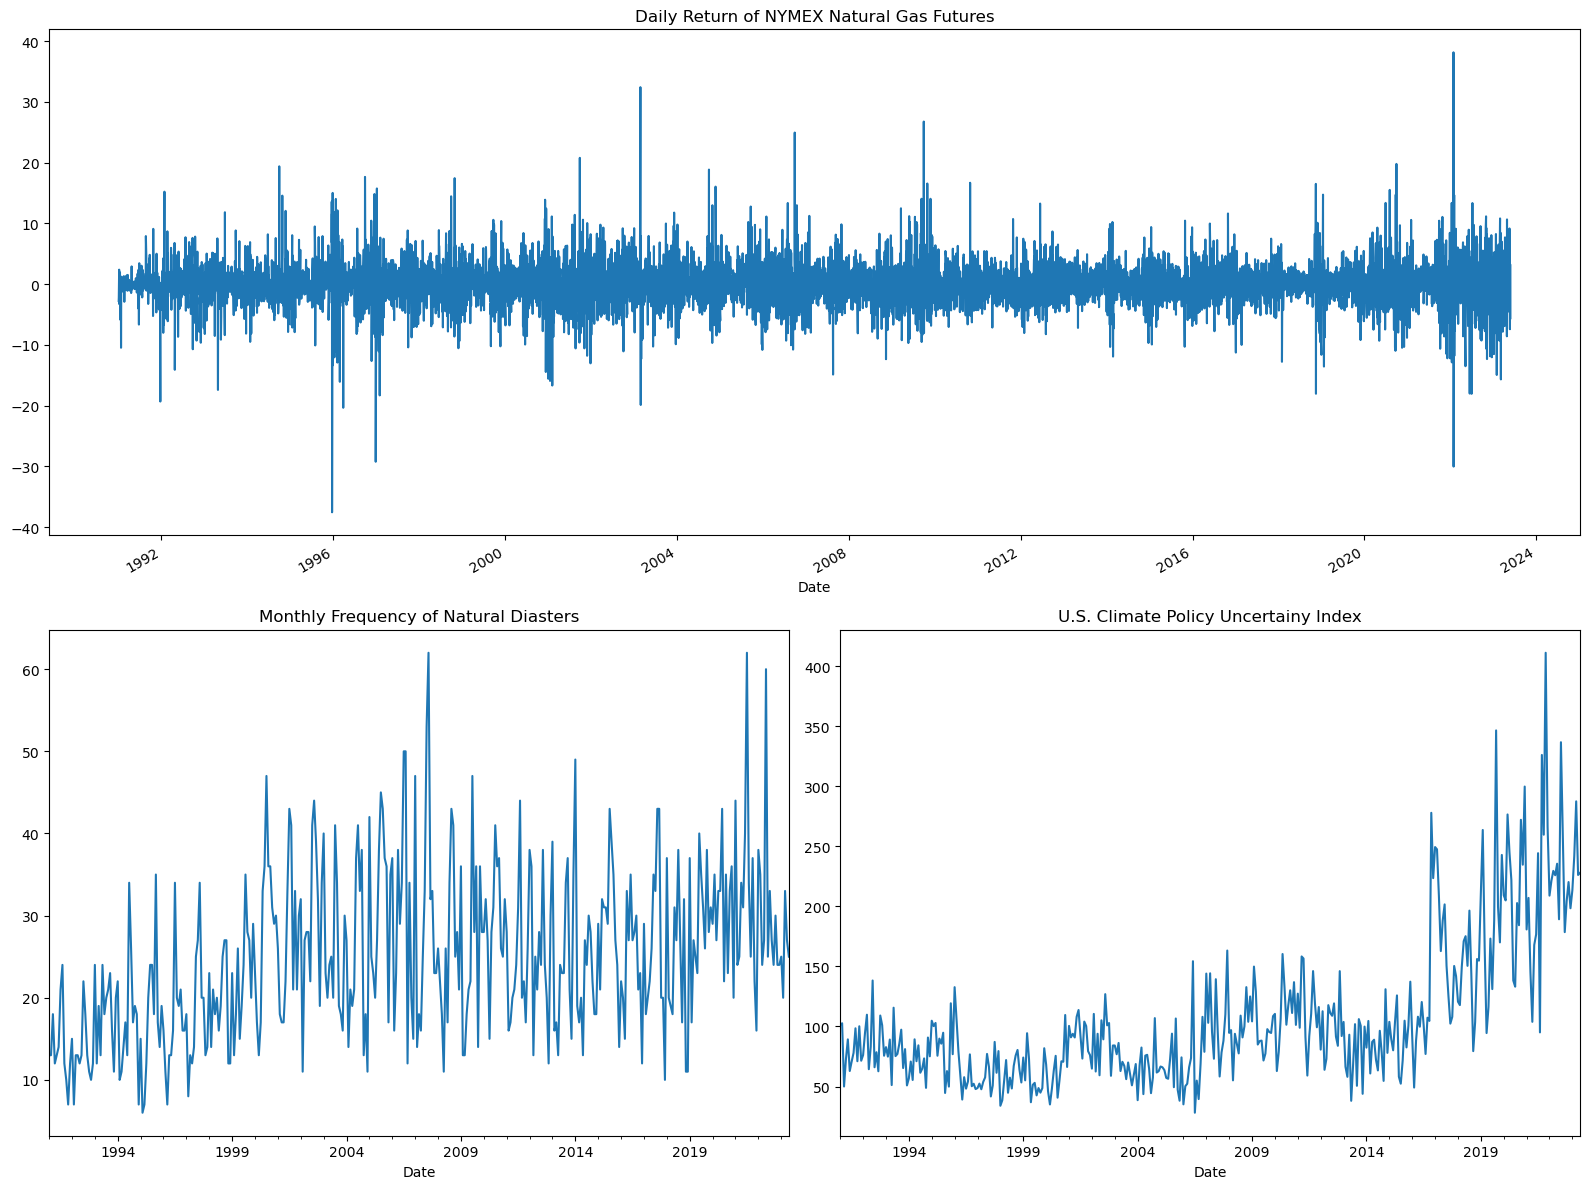

In [4]:
plot_eda(data)

In [5]:
get_descriptive_stats(data)

,Obs,mean,std,min,max,skewness,kurtosis,ADF
Data,,,,,,,,
Natural gas futures return (daily),8070,0.002161,3.616883,-37.574864,38.172676,0.083257,8.048973,-18.021501
CPU Index,389,105.695942,59.843765,28.161927,411.288806,1.739263,3.389606,-0.135402
d. ln(CPU Index),388,0.002092,0.366836,-1.701375,1.232682,-0.213719,0.834065,-8.054892
Natural disasters frequency,389,24.910026,9.990465,6.000000,62.000000,0.654542,0.390277,-2.560320
d. ln(Natural disasters frequency),388,0.001685,0.442629,-1.427116,1.339774,-0.035137,0.314798,-8.473852


In [6]:
run_kpss_test(data)

,KPSS Statistic,p-value
Data,,
Natural gas futures return (daily),0.058156,0.10
CPU Index,2.106133,0.01
d. CPU Index,0.231059,0.10
d. ln(CPU Index),0.155970,0.10
Natural disasters frequency,2.065823,0.01
d. Natural disasters frequency,0.061992,0.10
d. ln(Natural disasters frequency),0.062230,0.10


# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance, lag = 36

In [7]:
# Get required split for lag = 36
X_36train, X_36test, train36_returns, test36_returns, nbr_test_days36 =\
    is_os_split(data, '2022-12-01', 36, diff = 'first_order')

In [8]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.05, 0.09, 0.90, 1.1, 1, -2])

# method='L-BFGS-B', \
results = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[0], 36)) ## Limited Memory BFGS

results

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18650.603688585325
        x: [ 5.308e-02  8.650e-02  9.001e-01  7.632e-02 -8.459e-02
            -2.009e+00]
      nit: 76
      jac: [-2.037e-02 -6.912e-02 -8.549e-02  1.819e-02  2.547e-03
            -3.110e-01]
     nfev: 868
     njev: 124
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [9]:
_, _, _, tau, _, ht, T =  GARCH_MIDAS(results['x'], train36_returns, X_36train[0], 36, full_output=True)
summary_stats(GARCH_MIDAS, 
              T, 
              results['x'], 
              (train36_returns, X_36train[0], 36), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

,mu,alpha,beta,theta,omega,m
values,0.053079,8.650160e-02,0.900105,0.076324,-0.084586,-2.008527
p-val,0.055552,1.586787e-47,0.000000,0.000012,0.251411,0.210497


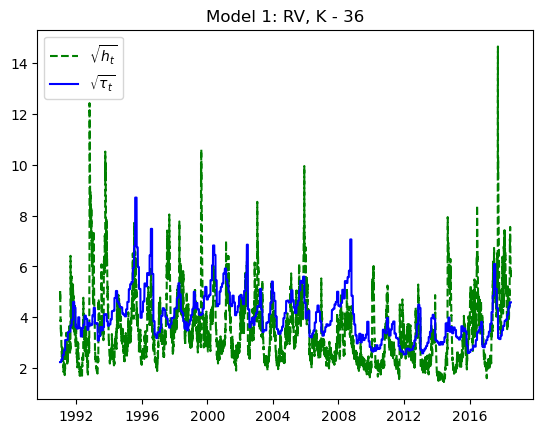

In [10]:
# Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

plot_results(date_array, ht, tau, title = 'Model 1: RV, K - 36')

---
## Two-factors GARCH-MIDAS

Model 2: RV + CPU, lag = 36

In [11]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.05, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

# method='L-BFGS-B', \
results2 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[:2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results2

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18650.627599592237
        x: [ 5.297e-02  8.660e-02  9.001e-01  7.642e-02  1.338e-01
            -8.375e-02  1.028e+00 -1.973e+00]
      nit: 41
      jac: [-1.168e-01  2.623e-01  2.288e-01  1.710e-02  1.112e+00
            -5.457e-03 -1.057e+00 -3.198e-01]
     nfev: 594
     njev: 66
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [12]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results2['x'], train36_returns, X_36train[:2], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results2['x'], 
              (train36_returns, X_36train[:2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])


,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.052968,8.660468e-02,0.900086,0.076421,0.133765,-0.083750,1.028017e+00,-1.973023
p-val,0.055039,3.552714e-47,0.000000,0.000013,0.254782,0.256263,5.419435e-15,0.211973


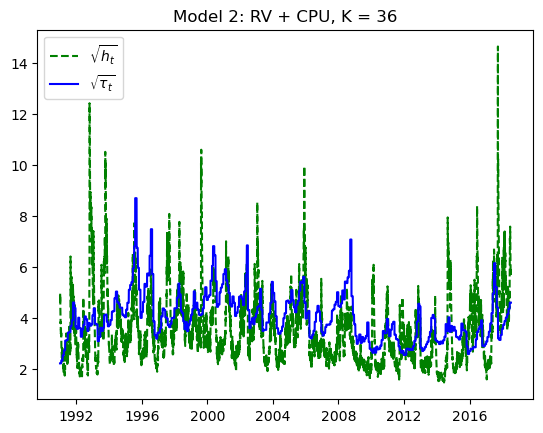

In [13]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 2: RV + CPU, K = 36')

Model 3: RV + EMDAT, K = 36

In [14]:
# method='L-BFGS-B', \
results3 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train36_returns, X_36train[::2], 36, get_twofactor_tau)) ## Limited Memory BFGS

results3

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18644.78837084961
        x: [ 5.552e-02  8.424e-02  9.015e-01  7.131e-02  2.045e+00
            -1.224e-01  1.989e+00 -1.640e+00]
      nit: 59
      jac: [ 7.167e-02 -3.129e-01 -2.343e-01 -1.717e-01 -3.154e-01
            -1.382e-02  7.185e-01 -2.554e-01]
     nfev: 927
     njev: 103
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [15]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results3['x'], train36_returns, X_36train[::2], 36, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results3['x'], 
              (train36_returns, X_36train[::2], 36, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.055524,8.423619e-02,0.901468,0.071307,2.044758,-0.122361,1.988533,-1.639828
p-val,0.047323,4.953264e-43,0.000000,0.000026,0.289323,0.171710,0.266238,0.245628


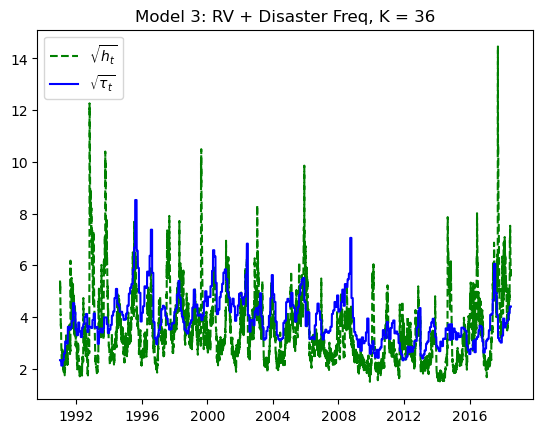

In [16]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 3: RV + Disaster Freq, K = 36')

Model 4: RV + EMDAT, K = 33

In [17]:
# Get required split for lag = 33
X_33train, X_33test, train33_returns, test33_returns, nbr_test_days33 =\
    is_os_split(data, '2022-12-01', 33, diff = 'first_order')

In [18]:
# method='L-BFGS-B', \
results4 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                  args = (train33_returns, X_33train[::2], 33, get_twofactor_tau)) ## Limited Memory BFGS

results4

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18829.844710058336
        x: [ 4.932e-02  9.324e-02  8.913e-01  6.467e-02  3.854e+00
             3.727e-01  9.590e-01 -9.542e-01]
      nit: 77
      jac: [ 9.895e-02 -2.756e+00 -2.068e+00  4.227e-01  3.369e-01
             1.965e-02  1.724e-01 -1.183e+00]
     nfev: 846
     njev: 94
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [19]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results4['x'], train33_returns, X_33train[::2], 33, get_tau=get_twofactor_tau, full_output=True)


summary_stats(GARCH_MIDAS, 
              T, 
              results4['x'], 
              (train33_returns, X_33train[::2], 33, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.049318,9.324184e-02,0.891304,0.064665,3.854199,0.372682,9.589829e-01,-0.954182
p-val,0.066293,1.488485e-43,0.000000,0.002975,0.000031,0.012240,5.421711e-21,0.397939


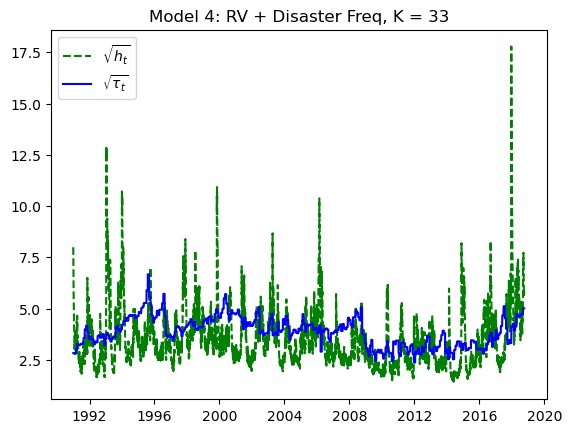

In [20]:
date_array33 = pd.date_range(start=start_date, periods=T, freq='B')

# Plot 
plot_results(date_array33, ht, tau, title = 'Model 4: RV + Disaster Freq, K = 33')

---
## Three-Factors GARCH-MIDAS
Model 5: RV + CPU + EMDAT, K = 36

In [21]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results5 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train36_returns, X_36train, 
                          36, get_threefactor_tau)) ## Limited Memory BFGS

results5

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18650.36913423839
        x: [ 5.324e-02  8.642e-02  9.002e-01  7.603e-02  1.335e-01
             1.415e-01 -8.457e-02  1.027e+00  1.028e+00 -1.976e+00]
      nit: 43
      jac: [ 6.366e-02  1.014e+00  7.691e-01 -3.227e-01  1.128e+00
            -1.792e+00 -1.059e-01 -1.061e+00 -8.931e-01 -3.289e-01]
     nfev: 781
     njev: 71
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [22]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results5['x'], train36_returns, X_36train, 36, get_tau=get_threefactor_tau, full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results5['x'], 
              (train36_returns, X_36train, 36, get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.053239,8.642080e-02,0.900177,0.076032,0.133533,0.141472,-0.084565,1.027185e+00,1.028401,-1.975797
p-val,0.053960,1.743546e-46,0.000000,0.000022,0.253327,0.284722,0.260265,1.481523e-17,0.000027,0.221252


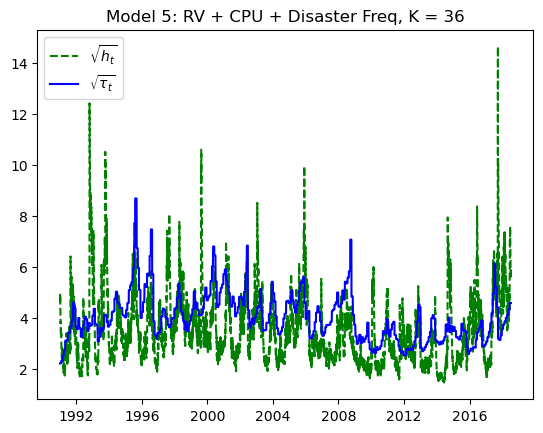

In [23]:
# Plot 
plot_results(date_array, ht, tau, title = 'Model 5: RV + CPU + Disaster Freq, K = 36')

Model 6: RV + CPU + EMDAT, K = 33

In [24]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

results6 = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',
                  args = (train33_returns, X_33train, 
                          33, get_threefactor_tau)) ## Limited Memory BFGS

results6

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 18823.31600934069
        x: [ 4.704e-02  8.949e-02  8.928e-01  3.008e-02  3.059e-01
             3.962e+00  1.223e-02  2.390e+00  9.405e-01  6.046e+00]
      nit: 159
      jac: [-5.275e-02 -2.852e+00 -1.048e+00  1.170e+00 -2.583e-02
            -8.367e-03 -9.750e-02 -4.875e-02  2.547e-02  9.823e-03]
     nfev: 2134
     njev: 194
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>

In [25]:
loglik, logliks, e, tau, gt, ht, T =  GARCH_MIDAS(results6['x'], 
                                                  train33_returns, X_33train, 
                                                  33, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True)

summary_stats(GARCH_MIDAS, 
              T, 
              results6['x'], 
              (train33_returns, X_33train, 
              33, 
              get_threefactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm'])


,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.047039,8.949233e-02,0.892808,3.008041e-02,0.305916,3.961939,0.012232,2.389569,9.404868e-01,6.045666e+00
p-val,0.092725,1.269808e-43,0.000000,2.997213e-08,0.127403,0.000013,0.486510,0.104652,6.097737e-22,1.713177e-09


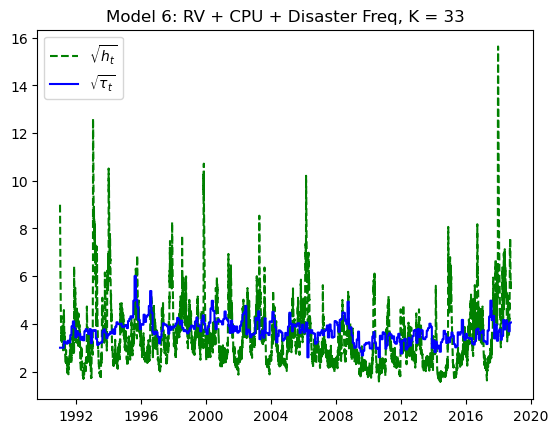

In [26]:
# Plot 
plot_results(date_array33, ht, tau, title = 'Model 6: RV + CPU + Disaster Freq, K = 33')

---
## Out-sample Analysis

$$L_{MSE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}(\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}})^2$$

$$L_{MAE} = \frac{1}{N_O - \sum_{t=1}^E N_t}\sum_{t = E+1}^{T}\sum_{i = 1}^{N_t}|\sigma_{i,t} - \sqrt{\hat{\tau_t}\hat{g_{i,t}}}|$$

In [27]:
df_realized_vol = pd.read_csv('./data/intraday_realized_volatility.csv', 
                              encoding_errors='ignore')

df_realized_vol.set_index('Date', inplace = True)
df_realized_vol.index = pd.to_datetime(df_realized_vol.index)

realized_vol = np.array(df_realized_vol.loc[df_realized_vol.index >= '2022-12-01', 'Volatility'])

In [28]:
LMSE1, LMAE1 = out_sample_test(test36_returns, realized_vol, X_36test[0], 36, results, nbr_test_days36, [10,30,60,90,118])
LMSE2, LMAE2 = out_sample_test(test36_returns, realized_vol, X_36test[:2], 36, results2, nbr_test_days36, [10,30,60,90,118])
LMSE3, LMAE3 = out_sample_test(test36_returns, realized_vol, X_36test[::2], 36, results3, nbr_test_days36, [10,30,60,90,118])
LMSE4, LMAE4 = out_sample_test(test33_returns, realized_vol, X_33test[::2], 33, results4, nbr_test_days33, [10,30,60,90,118])
LMSE5, LMAE5 = out_sample_test(test36_returns, realized_vol, X_36test, 36, results5, nbr_test_days36, [10,30,60,90,118])
LMSE6, LMAE6 = out_sample_test(test33_returns, realized_vol, X_33test, 33, results6, nbr_test_days33, [10,30,60,90,118])

In [29]:
pd.DataFrame({
    'MSE (RV, K = 36)' : LMSE1,
    'MAE (RV, K = 36)' : LMAE1,
    'MSE (RV + CPU, K = 36)' : LMSE2,
    'MAE (RV + CPU, K = 36)' : LMAE2,
    'MSE (RV + EMDAT, K = 36)' : LMSE3,
    'MAE (RV + EMDAT, K = 36)' : LMAE3,
    'MSE (RV + EMDAT, K = 33)' : LMSE4,
    'MAE (RV + EMDAT, K = 33)' : LMAE4,
    'MSE (RV + CPU + EMDAT, K = 36)' : LMSE5,
    'MAE (RV + CPU + EMDAT, K = 36)' : LMAE5,
    'MSE (RV + CPU + EMDAT, K = 33)' : LMSE6,
    'MAE (RV + CPU + EMDAT, K = 33)' : LMAE6,
}, index = ['10 days forecast','30 days forecast','60 days forecast','90 days forecast', '118 days forecast']).T

,10 days forecast,30 days forecast,60 days forecast,90 days forecast,118 days forecast
"MSE (RV, K = 36)",0.000046,0.000094,0.000129,0.000173,0.000159
"MAE (RV, K = 36)",0.005703,0.007915,0.009201,0.011031,0.010577
"MSE (RV + CPU, K = 36)",0.000048,0.000095,0.000130,0.000175,0.000160
"MAE (RV + CPU, K = 36)",0.005914,0.007979,0.009269,0.011098,0.010622
"MSE (RV + EMDAT, K = 36)",0.000035,0.000084,0.000123,0.000166,0.000153
"MAE (RV + EMDAT, K = 36)",0.004785,0.007284,0.008863,0.010728,0.010335
"MSE (RV + EMDAT, K = 33)",0.000059,0.000116,0.000118,0.000141,0.000139
"MAE (RV + EMDAT, K = 33)",0.006672,0.008980,0.008931,0.009971,0.009893
"MSE (RV + CPU + EMDAT, K = 36)",0.000048,0.000095,0.000130,0.000175,0.000160
"MAE (RV + CPU + EMDAT, K = 36)",0.005893,0.007953,0.009252,0.011078,0.010605


In [30]:
models_to_test =\
    [(test36_returns, X_36test[0],36,results, nbr_test_days36),
        (test36_returns, X_36test[:2],36,results2, nbr_test_days36),
        (test36_returns, X_36test[::2],36,results3, nbr_test_days36),
        (test33_returns, X_33test[::2],33,results4, nbr_test_days33),
        (test36_returns, X_36test,36,results5, nbr_test_days36),
        (test33_returns, X_33test,33,results6, nbr_test_days33)]

MCS_MSE_10, MCS_MAE_10 =\
    mcs_test(realized_vol, 
             models_to_test,
             10)

MCS_MSE_30, MCS_MAE_30 =\
    mcs_test(realized_vol, 
             models_to_test,
             30)

MCS_MSE_60, MCS_MAE_60 =\
    mcs_test(realized_vol, 
             models_to_test,
            60)

MCS_MSE_90, MCS_MAE_90 =\
    mcs_test(realized_vol, 
             models_to_test,
             90)

MCS_MSE_118, MCS_MAE_118 =\
    mcs_test(realized_vol, 
             models_to_test,
             118)

Computing MCS: 100%|██████████| 5/5 [00:00<00:00, 833.16model/s]


In [31]:
MCS10 = pd.merge(MCS_MSE_10.sort_index()[['pvalues']],MCS_MAE_10.sort_index()[['pvalues']], on = 'models',how='inner')
MCS30 = pd.merge(MCS_MSE_30.sort_index()[['pvalues']],MCS_MAE_30.sort_index()[['pvalues']], on = 'models',how='inner')
MCS60 = pd.merge(MCS_MSE_60.sort_index()[['pvalues']],MCS_MAE_60.sort_index()[['pvalues']], on = 'models',how='inner')
MCS90 = pd.merge(MCS_MSE_90.sort_index()[['pvalues']],MCS_MAE_90.sort_index()[['pvalues']], on = 'models',how='inner')
MCS118 = pd.merge(MCS_MSE_118.sort_index()[['pvalues']],MCS_MAE_118.sort_index()[['pvalues']], on = 'models',how='inner')

In [32]:
merged_mcs = pd.concat([MCS10, MCS30,MCS60,MCS90,MCS118], keys=['10 days', '30 days', '60 days', '90 days', '120 days'])
merged_mcs = merged_mcs.rename(columns={'pvalues_x' : 'MCS_mae', 'pvalues_y' : 'MCS_mse'})
new_index_values = ['RV (K=36)', 'RV+CPU (K=36)', 'RV+EMDAT (K=36)', 'RV+EMDAT (K=33)', 'RV+CPU+EMDAT (K=36)','RV+CPU+EMDAT (K=33)']  # New values for the second level index
merged_mcs.index = merged_mcs.index.set_levels(new_index_values, level=1)
merged_mcs

MCS_mae  MCS_mse
         models                               
10 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
30 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
60 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
90 days  RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0
120 days RV (K=36)                0.0      0.0
         RV+CPU (K=36)            0.0      0.0
         RV+EMDAT (K=36)          0.0      0.0
         RV+EMDAT (K=33)          0.0      0.0
         RV+CPU+EMDAT (K=36)      0.0      0.0
         RV+CPU+EMDAT (K=33)      1.0      1.0

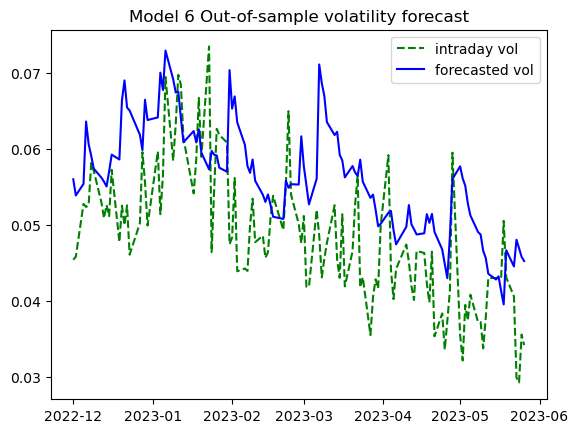

In [37]:
loglik, logliks, e, tau, gt, ht, T =\
    GARCH_MIDAS(results6['x'], 
                test33_returns, X_33test, 
                33, 
                get_tau=get_threefactor_tau, 
                full_output=True)

rlzd_daily_vol = realized_vol/np.sqrt(252)
forecast_vol = np.sqrt(ht[-nbr_test_days33:])/100

x = np.array(data.index[data.index >= '2022-12-01'])

plt.title("Model 6 Out-of-sample volatility forecast")

plt.plot(x, rlzd_daily_vol, 'g--', label = 'intraday vol')
plt.plot(x, forecast_vol,'b-', label = 'forecasted vol')
plt.legend()
plt.show()